In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


# 讀取數據
account_info = pd.read_csv('.\Train\\train_account_info.csv')
customer_info = pd.read_csv('.\Train\\train_customer_info.csv')
account_transactions = pd.read_csv('.\Train\\train_account_transactions.csv')
suspicious_accounts = pd.read_csv('.\Train\\train_suspicious_accounts.csv')

# 測試集數據
test_account_info = pd.read_csv('.\Test\\test_account_info.csv')
test_customer_info = pd.read_csv('.\Test\\test_customer_info.csv')
test_transactions = pd.read_csv('.\Test\\test_account_transactions.csv')

In [32]:
# 檢視資料大小
print(f"Account Info 形狀: {account_info.shape}")
print(f"Account Transactions 形狀: {account_transactions.shape}")
print(f"Customer Info 形狀: {customer_info.shape}")
print(f"Suspicious Accounts 形狀: {suspicious_accounts.shape}")

Account Info 形狀: (24969, 5)
Account Transactions 形狀: (206333, 18)
Customer Info 形狀: (23655, 5)
Suspicious Accounts 形狀: (400, 3)


In [33]:
# 2. 創建客戶-帳戶的對應關係作為基礎
account_customer_map = account_info[['account_number', 'customer_id']].drop_duplicates()
print(f"客戶-帳戶映射表形狀: {account_customer_map.shape}")

# 3. 合併客戶資訊
merged_data = pd.merge(
    account_customer_map, 
    customer_info, 
    on='customer_id', 
    how='left'
)
print(f"合併客戶資訊後的形狀: {merged_data.shape}")

# 4. 合併帳戶資訊(其他帳戶特徵，如是否無法聯繫，是否為數位帳戶等)
print("\n合併帳戶資訊...")
merged_data = pd.merge(
    merged_data,
    account_info.drop('customer_id', axis=1),  # 已經有客戶ID，所以這裡移除
    on='account_number',
    how='left'
)
print(f"合併帳戶資訊後的形狀: {merged_data.shape}")
print(merged_data.head())

客戶-帳戶映射表形狀: (24969, 2)
合併客戶資訊後的形狀: (24969, 6)

合併帳戶資訊...
合併帳戶資訊後的形狀: (24969, 9)
  account_number customer_id  aum_amt  age  income_level  region_code  \
0       ACCT6068      ID5684   256930   61          25.0         12.0   
1      ACCT11459     ID10838       65   57           NaN         12.0   
2      ACCT15832     ID15012    14438   56         126.0         12.0   
3      ACCT15612     ID14797    43872   46           NaN         12.0   
4      ACCT18659     ID17677  2578166   72          25.0         12.0   

   is_unreachable  is_digital_account  account_open_date  
0               0                   0               8400  
1               0                   0               9569  
2               0                   0               8380  
3               0                   0              10610  
4               0                   0               9666  


In [34]:
# 5. 基於customer_id排序
print("\n基於customer_id排序資料...")
merged_data = merged_data.sort_values(by='customer_id')
print("排序後的資料前5行:")
print(merged_data.head())

# 6. 如果需要，可以將排序後的資料保存為CSV
merged_data.to_csv('sorted_merged_data.csv', index=False)
print("\n排序完成！")


基於customer_id排序資料...
排序後的資料前5行:
      account_number customer_id   aum_amt  age  income_level  region_code  \
1968           ACCT0         ID0      1281   34         126.0         12.0   
18819          ACCT1         ID1  56019182   43         350.0         12.0   
18859          ACCT2         ID1  56019182   43         350.0         12.0   
18876          ACCT3         ID1  56019182   43         350.0         12.0   
18915          ACCT4         ID1  56019182   43         350.0         12.0   

       is_unreachable  is_digital_account  account_open_date  
1968                0                   1              17642  
18819               0                   0              17359  
18859               0                   0              17057  
18876               0                   0              17240  
18915               0                   0              17359  

排序完成！


In [35]:
# 2. 從交易數據中提取特徵
print("\n從交易數據中提取特徵...")

# 統計每個帳戶的交易次數
transaction_count = account_transactions.groupby('account_number').size().reset_index(name='transaction_count')

# 計算每個帳戶的平均交易金額
transaction_amount_mean = account_transactions.groupby('account_number')['transaction_amount'].mean().reset_index(name='avg_transaction_amount')

# 計算每個帳戶的總交易金額
transaction_amount_sum = account_transactions.groupby('account_number')['transaction_amount'].sum().reset_index(name='total_transaction_amount')

# 計算每個帳戶的交易金額標準差(波動性)
transaction_amount_std = account_transactions.groupby('account_number')['transaction_amount'].std().reset_index(name='std_transaction_amount')

# 計算每個帳戶的最大交易金額
transaction_amount_max = account_transactions.groupby('account_number')['transaction_amount'].max().reset_index(name='max_transaction_amount')

# 計算交易方向比例(1: 入帳, 0: 出帳)
transaction_direction = account_transactions.groupby('account_number')['transaction_direction'].mean().reset_index(name='income_ratio')

# 計算行動銀行的使用頻率
mobile_banking_usage = account_transactions.groupby('account_number')['mobile_banking_check_count'].sum().reset_index(name='mobile_banking_usage')

# 計算網路銀行的使用頻率
ebanking_usage = account_transactions.groupby('account_number')['ebanking_check_count'].sum().reset_index(name='ebanking_usage')

# 計算相同IP和相同裝置的比例
same_ip_ratio = account_transactions.groupby('account_number')['is_same_ip'].mean().reset_index(name='same_ip_ratio')
same_device_ratio = account_transactions.groupby('account_number')['is_same_device'].mean().reset_index(name='same_device_ratio')

# 特殊帳號交易處理：ACCT31429 和 ID99999
# 統計與特殊帳號的交易
account_bank_txn = account_transactions[account_transactions['counterparty_account'] == 'ACCT31429']
bank_txn_count = account_bank_txn.groupby('account_number').size().reset_index(name='bank_txn_count')
bank_txn_avg = account_bank_txn.groupby('account_number')['transaction_amount'].mean().reset_index(name='avg_bank_txn_amount')

account_virtual_txn = account_transactions[account_transactions['counterparty_customer_id'] == 'ID99999']
virtual_txn_count = account_virtual_txn.groupby('account_number').size().reset_index(name='virtual_txn_count')
virtual_txn_avg = account_virtual_txn.groupby('account_number')['transaction_amount'].mean().reset_index(name='avg_virtual_txn_amount')

# 計算交易對方多樣性(不同交易對手的數量)
counterparty_diversity = account_transactions.groupby('account_number')['counterparty_account'].nunique().reset_index(name='counterparty_diversity')

# 計算交易渠道使用次數
channel_usage = pd.get_dummies(account_transactions['transaction_channel']).groupby(account_transactions['account_number']).sum()
channel_usage.columns = [f'channel_{col}_count' for col in channel_usage.columns]

# 計算交易代碼使用次數
code_usage = pd.get_dummies(account_transactions['transaction_code']).groupby(account_transactions['account_number']).sum()
code_usage.columns = [f'code_{col}_count' for col in code_usage.columns]


# 3. 合併所有交易特徵到一個數據框
transaction_features = transaction_count
for feature in [transaction_amount_mean, transaction_amount_sum, transaction_amount_std, 
                transaction_amount_max, transaction_direction, mobile_banking_usage, 
                ebanking_usage, same_ip_ratio, same_device_ratio, bank_txn_count, 
                bank_txn_avg, virtual_txn_count, virtual_txn_avg, counterparty_diversity,
                channel_usage, code_usage]:  # 加入新的特徵
    transaction_features = pd.merge(
        transaction_features,
        feature,
        on='account_number',
        how='left'
    )

print(f"交易特徵的形狀: {transaction_features.shape}")

# 4. 將交易特徵合併到主數據集
print("\n合併交易特徵到主數據集...")
merged_data_with_txn = pd.merge(
    merged_data,
    transaction_features,
    on='account_number',
    how='left'
)

# 5. 填充缺失值
print("\n處理缺失值...")
# 填充交易特徵的缺失值為0 (沒有交易的帳戶)
numeric_txn_cols = transaction_features.columns.drop('account_number')
for col in numeric_txn_cols:
    merged_data_with_txn[col] = merged_data_with_txn[col].fillna(0)

print(f"最終合併數據的形狀: {merged_data_with_txn.shape}")

# 6. 顯示合併後的數據
print("\n合併後的數據前5行:")
print(merged_data_with_txn.head())

# 7. 保存合併後的數據
merged_data_with_txn.to_csv('merged_data_with_transactions.csv', index=False)
print("\n已保存合併後的數據到 'merged_data_with_transactions.csv'")


從交易數據中提取特徵...
交易特徵的形狀: (24969, 85)

合併交易特徵到主數據集...

處理缺失值...
最終合併數據的形狀: (24969, 93)

合併後的數據前5行:
  account_number customer_id   aum_amt  age  income_level  region_code  \
0          ACCT0         ID0      1281   34         126.0         12.0   
1          ACCT1         ID1  56019182   43         350.0         12.0   
2          ACCT2         ID1  56019182   43         350.0         12.0   
3          ACCT3         ID1  56019182   43         350.0         12.0   
4          ACCT4         ID1  56019182   43         350.0         12.0   

   is_unreachable  is_digital_account  account_open_date  transaction_count  \
0               0                   1              17642                  7   
1               0                   0              17359                  1   
2               0                   0              17057                  1   
3               0                   0              17240                  1   
4               0                   0              17359       

In [36]:
# 8. 添加可疑帳戶標記
print("\n添加可疑帳戶標記...")

# 創建可疑帳戶列表（使用帳戶號碼）
suspicious_accounts_list = suspicious_accounts['account_number'].tolist()

# 添加is_suspicious標記
merged_data_with_txn['is_suspicious'] = merged_data_with_txn['account_number'].apply(
    lambda x: 1 if x in suspicious_accounts_list else 0
)

# 顯示可疑帳戶數量統計
suspicious_count = merged_data_with_txn['is_suspicious'].sum()
total_accounts = len(merged_data_with_txn)
print(f"可疑帳戶數量: {suspicious_count} ({suspicious_count/total_accounts:.2%})")
print(f"非可疑帳戶數量: {total_accounts - suspicious_count} ({(total_accounts - suspicious_count)/total_accounts:.2%})")

# 查看帶有可疑標記的數據
print("\n帶有可疑標記的數據前5行:")
print(merged_data_with_txn[['account_number', 'customer_id', 'is_suspicious']].head())

# 查看可疑帳戶的數據
print("\n可疑帳戶示例 (5筆):")
print(merged_data_with_txn[merged_data_with_txn['is_suspicious'] == 1][['account_number', 'customer_id', 'is_suspicious']].head())

# 保存帶有可疑標記的完整數據
merged_data_with_txn.to_csv('full_dataset_with_suspicious_flag.csv', index=False)
print("\n已保存帶有可疑標記的完整數據到 'full_dataset_with_suspicious_flag.csv'")


添加可疑帳戶標記...
可疑帳戶數量: 400 (1.60%)
非可疑帳戶數量: 24569 (98.40%)

帶有可疑標記的數據前5行:
  account_number customer_id  is_suspicious
0          ACCT0         ID0              0
1          ACCT1         ID1              0
2          ACCT2         ID1              0
3          ACCT3         ID1              0
4          ACCT4         ID1              0

可疑帳戶示例 (5筆):
    account_number customer_id  is_suspicious
57       ACCT10648     ID10059              1
66        ACCT1078      ID1007              1
67       ACCT10659     ID10070              1
113      ACCT10710     ID10121              1
122      ACCT10720     ID10131              1

已保存帶有可疑標記的完整數據到 'full_dataset_with_suspicious_flag.csv'


In [37]:
merged_data_with_txn

,account_number,customer_id,aum_amt,age,income_level,region_code,is_unreachable,is_digital_account,account_open_date,transaction_count,...,code_46_count,code_47_count,code_48_count,code_49_count,code_50_count,code_51_count,code_52_count,code_53_count,code_54_count,is_suspicious
0,ACCT0,ID0,1281,34,126.0,12.0,0,1,17642,7,...,0,0,0,0,0,0,0,0,0,0
1,ACCT1,ID1,56019182,43,350.0,12.0,0,0,17359,1,...,0,0,0,0,0,0,0,0,0,0
2,ACCT2,ID1,56019182,43,350.0,12.0,0,0,17057,1,...,0,0,0,0,0,0,0,0,0,0
3,ACCT3,ID1,56019182,43,350.0,12.0,0,0,17240,1,...,0,0,0,0,0,0,0,0,0,0
4,ACCT4,ID1,56019182,43,350.0,12.0,0,0,17359,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24964,ACCT10580,ID9993,4624626,58,126.0,12.0,0,0,9563,15,...,0,0,0,0,0,0,0,0,0,0
24965,ACCT10581,ID9994,16243,42,25.0,12.0,0,0,18143,3,...,0,0,0,0,0,0,0,0,0,0
24966,ACCT10582,ID9995,223,23,126.0,12.0,0,1,17725,20,...,0,2,0,0,0,0,0,0,0,0
24967,ACCT10583,ID9996,0,27,126.0,12.0,0,1,16000,2,...,0,0,0,0,0,0,0,0,0,0


In [38]:
# 9. 準備機器學習數據

# 處理缺失值 (針對非交易特徵的數值列)
print("\n處理剩餘缺失值...")
# 使用中位數填充年齡和收入等級的缺失值
if 'age' in merged_data_with_txn.columns:
    merged_data_with_txn['age'] = merged_data_with_txn['age'].fillna(merged_data_with_txn['age'].median())
if 'income_level' in merged_data_with_txn.columns:
    merged_data_with_txn['income_level'] = merged_data_with_txn['income_level'].fillna(merged_data_with_txn['income_level'].median())
if 'region_code' in merged_data_with_txn.columns:
    merged_data_with_txn['region_code'] = merged_data_with_txn['region_code'].fillna(merged_data_with_txn['region_code'].median())

# 準備特徵和標籤
X = merged_data_with_txn.drop(['is_suspicious', 'account_number', 'customer_id'], axis=1)
y = merged_data_with_txn['is_suspicious']

# 將數據分為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n訓練集特徵形狀: {X_train.shape}")
print(f"測試集特徵形狀: {X_test.shape}")
print(f"訓練集標籤分布:\n{y_train.value_counts()}")
print(f"測試集標籤分布:\n{y_test.value_counts()}")

# 特徵標準化 (針對數值特徵)
scaler = StandardScaler()
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

print("\n特徵標準化完成")

# 保存處理後的數據
train_data = pd.DataFrame(X_train, columns=X.columns)
train_data['is_suspicious'] = y_train.values
test_data = pd.DataFrame(X_test, columns=X.columns)
test_data['is_suspicious'] = y_test.values

train_data.to_csv('train_data_with_label.csv', index=False)
test_data.to_csv('test_data_with_label.csv', index=False)
print("\n已保存處理後的訓練集和測試集")


處理剩餘缺失值...

訓練集特徵形狀: (19975, 91)
測試集特徵形狀: (4994, 91)
訓練集標籤分布:
is_suspicious
0    19655
1      320
Name: count, dtype: int64
測試集標籤分布:
is_suspicious
0    4914
1      80
Name: count, dtype: int64

特徵標準化完成

已保存處理後的訓練集和測試集



開始訓練模型...

訓練隨機森林模型...
隨機森林訓練時間: 0.37 秒

隨機森林模型評估:
[[4874   40]
 [  39   41]]

分類報告:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4914
           1       0.51      0.51      0.51        80

    accuracy                           0.98      4994
   macro avg       0.75      0.75      0.75      4994
weighted avg       0.98      0.98      0.98      4994

ROC AUC: 0.9438

訓練XGBoost模型...
XGBoost訓練時間: 0.26 秒

XGBoost模型評估:
[[4808  106]
 [  20   60]]

分類報告:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      4914
           1       0.36      0.75      0.49        80

    accuracy                           0.97      4994
   macro avg       0.68      0.86      0.74      4994
weighted avg       0.99      0.97      0.98      4994

ROC AUC: 0.9674

隨機森林特徵重要性:
                     feature  importance
9   total_transaction_amount    0.102400
38          channel_17_count    0.099512
0        

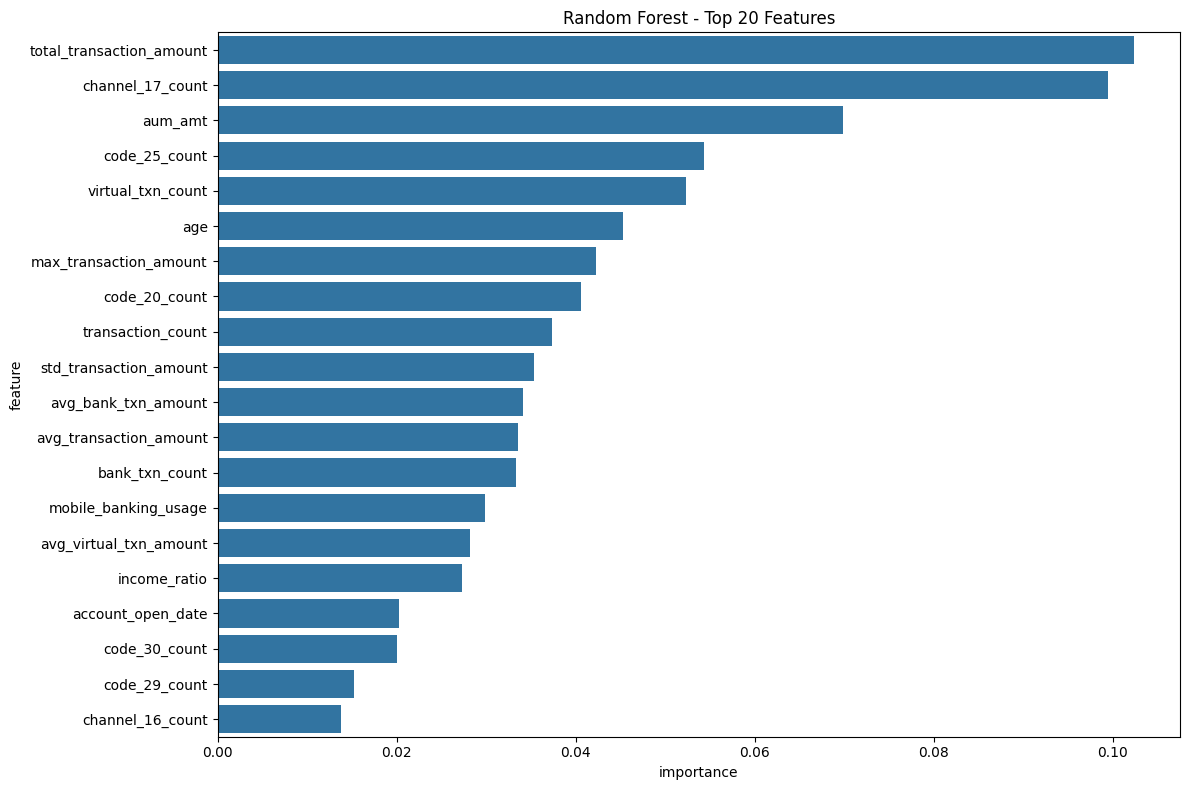

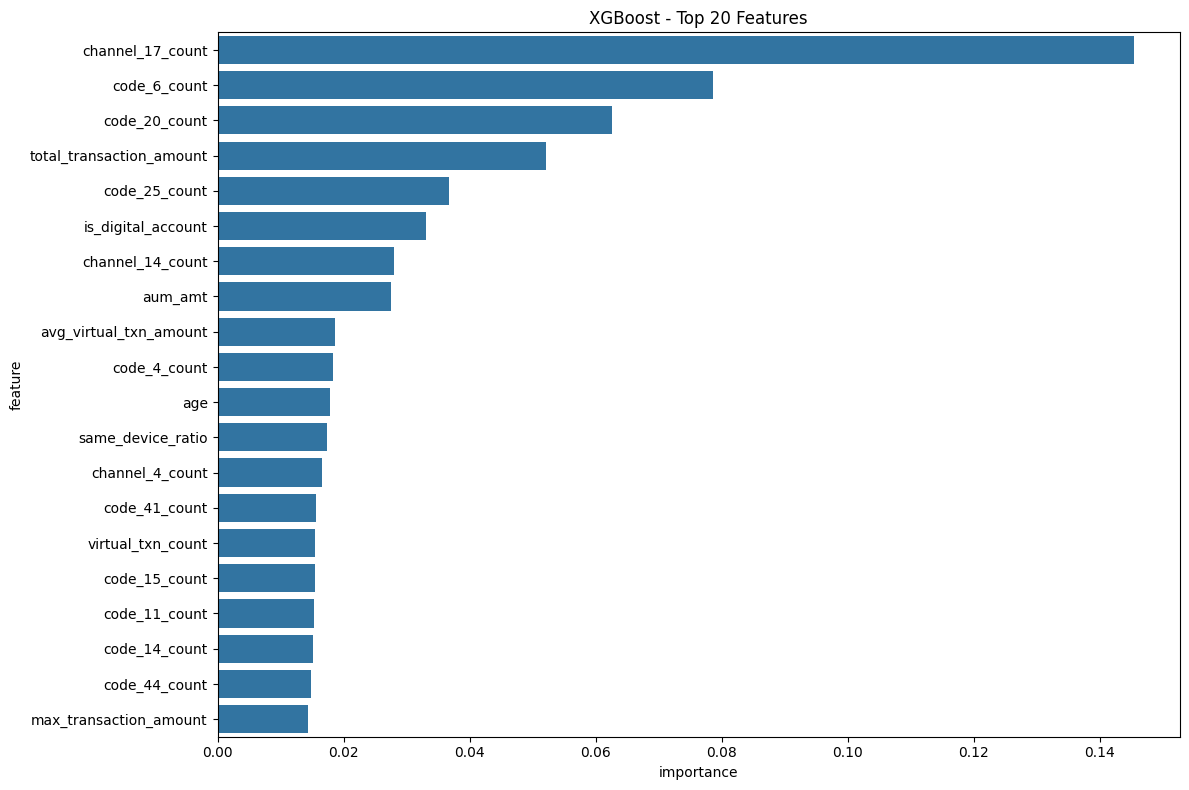

In [39]:
# 10. 訓練模型
print("\n開始訓練模型...")

# 由於類別不平衡，需要設置適當的參數
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import time

# 隨機森林模型
print("\n訓練隨機森林模型...")
start_time = time.time()
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=4,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
rf_train_time = time.time() - start_time
print(f"隨機森林訓練時間: {rf_train_time:.2f} 秒")

# 評估隨機森林模型
rf_y_pred = rf_model.predict(X_test)
rf_y_prob = rf_model.predict_proba(X_test)[:, 1]

print("\n隨機森林模型評估:")
print(confusion_matrix(y_test, rf_y_pred))
print("\n分類報告:")
print(classification_report(y_test, rf_y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, rf_y_prob):.4f}")

# XGBoost模型
print("\n訓練XGBoost模型...")
start_time = time.time()
# 計算正樣本權重
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
xgb_train_time = time.time() - start_time
print(f"XGBoost訓練時間: {xgb_train_time:.2f} 秒")

# 評估XGBoost模型
xgb_y_pred = xgb_model.predict(X_test)
xgb_y_prob = xgb_model.predict_proba(X_test)[:, 1]

print("\nXGBoost模型評估:")
print(confusion_matrix(y_test, xgb_y_pred))
print("\n分類報告:")
print(classification_report(y_test, xgb_y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, xgb_y_prob):.4f}")

# 特徵重要性
print("\n隨機森林特徵重要性:")
rf_feature_imp = pd.DataFrame(
    {'feature': X.columns, 'importance': rf_model.feature_importances_}
).sort_values('importance', ascending=False)
print(rf_feature_imp.head(10))

print("\nXGBoost特徵重要性:")
xgb_feature_imp = pd.DataFrame(
    {'feature': X.columns, 'importance': xgb_model.feature_importances_}
).sort_values('importance', ascending=False)
print(xgb_feature_imp.head(10))

# 繪製前20個重要特徵
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=rf_feature_imp.head(20))
plt.title('Random Forest - Top 20 Features')
plt.tight_layout()
plt.savefig('rf_feature_importance.png')

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=xgb_feature_imp.head(20))
plt.title('XGBoost - Top 20 Features')
plt.tight_layout()
plt.savefig('xgb_feature_importance.png')

# 保存模型
import pickle
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
print("\n模型已保存到 'rf_model.pkl' 和 'xgb_model.pkl'")

In [40]:
# 11. 優化模型 - 處理類別不平衡和特徵工程 (修正版2)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, f1_score
from imblearn.over_sampling import SMOTE
import time
import warnings
warnings.filterwarnings('ignore')

print("\n開始優化模型...")

# 讀取處理後的數據
merged_data_with_txn = pd.read_csv('full_dataset_with_suspicious_flag.csv')

# 處理缺失值
print("\n處理缺失值...")
if 'age' in merged_data_with_txn.columns:
    merged_data_with_txn['age'] = merged_data_with_txn['age'].fillna(merged_data_with_txn['age'].median())
if 'income_level' in merged_data_with_txn.columns:
    merged_data_with_txn['income_level'] = merged_data_with_txn['income_level'].fillna(merged_data_with_txn['income_level'].median())
if 'region_code' in merged_data_with_txn.columns:
    merged_data_with_txn['region_code'] = merged_data_with_txn['region_code'].fillna(merged_data_with_txn['region_code'].median())

# 檢查數據類型，只對數值型列處理
numeric_columns = merged_data_with_txn.select_dtypes(include=['float64', 'int64']).columns.tolist()
print(f"\n發現 {len(numeric_columns)} 個數值型列")

# 1. 創建新特徵
print("\n創建新特徵...")

# 1.1 帳戶存在天數 (使用account_open_date)
if 'account_open_date' in numeric_columns:
    merged_data_with_txn['account_age'] = 18250 - merged_data_with_txn['account_open_date']  # 假設最新日期為18250

# 1.2 交易頻率 (交易次數/帳戶年齡) - 處理極端值
if all(col in numeric_columns for col in ['transaction_count', 'account_age']):
    merged_data_with_txn['transaction_frequency'] = merged_data_with_txn['transaction_count'] / (merged_data_with_txn['account_age'] / 365 + 0.001)
    # 處理極端值 - 使用百分位數裁剪
    q99 = merged_data_with_txn['transaction_frequency'].quantile(0.99)
    merged_data_with_txn['transaction_frequency'] = merged_data_with_txn['transaction_frequency'].clip(upper=q99)

# 1.3 平均交易金額與資產總額的比率 - 處理極端值
if all(col in numeric_columns for col in ['avg_transaction_amount', 'aum_amt']):
    merged_data_with_txn['avg_txn_to_aum_ratio'] = merged_data_with_txn['avg_transaction_amount'] / (merged_data_with_txn['aum_amt'] + 1)
    # 處理極端值
    q99 = merged_data_with_txn['avg_txn_to_aum_ratio'].quantile(0.99)
    merged_data_with_txn['avg_txn_to_aum_ratio'] = merged_data_with_txn['avg_txn_to_aum_ratio'].clip(upper=q99)

# 1.4 最大交易金額與資產總額的比率 - 處理極端值
if all(col in numeric_columns for col in ['max_transaction_amount', 'aum_amt']):
    merged_data_with_txn['max_txn_to_aum_ratio'] = merged_data_with_txn['max_transaction_amount'] / (merged_data_with_txn['aum_amt'] + 1)
    # 處理極端值
    q99 = merged_data_with_txn['max_txn_to_aum_ratio'].quantile(0.99)
    merged_data_with_txn['max_txn_to_aum_ratio'] = merged_data_with_txn['max_txn_to_aum_ratio'].clip(upper=q99)

# 1.5 交易行為異常分數 - 處理極端值
if all(col in numeric_columns for col in ['std_transaction_amount', 'avg_transaction_amount']):
    merged_data_with_txn['txn_volatility'] = merged_data_with_txn['std_transaction_amount'] / (merged_data_with_txn['avg_transaction_amount'] + 1)
    # 處理極端值
    q99 = merged_data_with_txn['txn_volatility'].quantile(0.99)
    merged_data_with_txn['txn_volatility'] = merged_data_with_txn['txn_volatility'].clip(upper=q99)

# 1.6 入帳與出帳的比例 - 處理極端值和零值
if 'income_ratio' in numeric_columns:
    # 避免除以零，將0替換為0.001
    outgoing_ratio = 1 - merged_data_with_txn['income_ratio']
    outgoing_ratio = outgoing_ratio.replace(0, 0.001)
    merged_data_with_txn['inout_ratio'] = merged_data_with_txn['income_ratio'] / outgoing_ratio
    # 處理極端值
    q99 = merged_data_with_txn['inout_ratio'].quantile(0.99)
    merged_data_with_txn['inout_ratio'] = merged_data_with_txn['inout_ratio'].clip(upper=q99)

# 1.7 銀行交易比例 - 處理極端值和零值
if all(col in numeric_columns for col in ['bank_txn_count', 'transaction_count']):
    merged_data_with_txn['bank_txn_ratio'] = merged_data_with_txn['bank_txn_count'] / (merged_data_with_txn['transaction_count'] + 0.001)

# 1.8 網路行動銀行使用比例 
if all(col in numeric_columns for col in ['mobile_banking_usage', 'ebanking_usage', 'transaction_count']):
    merged_data_with_txn['digital_banking_ratio'] = (merged_data_with_txn['mobile_banking_usage'] + merged_data_with_txn['ebanking_usage']) / (merged_data_with_txn['transaction_count'] + 0.001)

# 1.9 IP和設備行為異常指標
if all(col in numeric_columns for col in ['same_ip_ratio', 'same_device_ratio']):
    merged_data_with_txn['device_change_score'] = (1 - merged_data_with_txn['same_ip_ratio']) + (1 - merged_data_with_txn['same_device_ratio'])

# 檢查並處理無限值和NaN
print("\n處理無限值和NaN...")
# 更新數值列列表，包括新創建的特徵
numeric_columns = merged_data_with_txn.select_dtypes(include=['float64', 'int64']).columns.tolist()

for col in numeric_columns:
    # 檢查並替換無限值
    merged_data_with_txn[col] = merged_data_with_txn[col].replace([np.inf, -np.inf], np.nan)
    
    # 檢查NaN值並填充
    nan_count = merged_data_with_txn[col].isna().sum()
    if nan_count > 0:
        print(f"列 {col} 有 {nan_count} 個NaN值")
        merged_data_with_txn[col] = merged_data_with_txn[col].fillna(merged_data_with_txn[col].median() if merged_data_with_txn[col].notnull().any() else 0)



開始優化模型...

處理缺失值...

發現 92 個數值型列

創建新特徵...

處理無限值和NaN...


In [41]:
# 2. 特徵選擇 - 移除高度相關的特徵
print("\n移除高度相關特徵...")

# 準備特徵和標籤
X = merged_data_with_txn.drop(['is_suspicious', 'account_number', 'customer_id'], axis=1)
y = merged_data_with_txn['is_suspicious']

# 計算特徵相關性
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper.columns if any(upper[column] > 0.95)]

# 顯示將被移除的高度相關特徵
if high_corr_features:
    print(f"移除 {len(high_corr_features)} 個高度相關特徵: {high_corr_features[:5]}...")
    X = X.drop(high_corr_features, axis=1)



移除高度相關特徵...
移除 6 個高度相關特徵: ['virtual_txn_count', 'avg_virtual_txn_amount', 'code_34_count', 'code_44_count', 'code_49_count']...


In [42]:
# 3. 將數據分為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n特徵工程後的特徵數量: {X.shape[1]}")
print(f"訓練集特徵形狀: {X_train.shape}")
print(f"測試集特徵形狀: {X_test.shape}")


特徵工程後的特徵數量: 93
訓練集特徵形狀: (19975, 93)
測試集特徵形狀: (4994, 93)


In [43]:
# 4. 使用健壯縮放器和SMOTE處理類別不平衡
print("\n使用健壯縮放器和SMOTE處理類別不平衡...")

# 使用健壯縮放器，更能處理異常值
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
robust_scaler = RobustScaler()  # 使用健壯縮放代替標準縮放

# 應用健壯縮放
X_train_scaled = X_train.copy()
X_train_scaled[numeric_features] = robust_scaler.fit_transform(X_train[numeric_features])

# 測試集也進行健壯縮放
X_test_scaled = X_test.copy()
X_test_scaled[numeric_features] = robust_scaler.transform(X_test[numeric_features])

# SMOTE設置
print("\n應用SMOTE過採樣...")
sampling_strategy = 0.3  # 少數類別將達到多數類別的30%
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

# 應用SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"SMOTE重採樣後訓練集形狀: {X_train_resampled.shape}")
print(f"重採樣後類別分布:\n{pd.Series(y_train_resampled).value_counts()}")


使用健壯縮放器和SMOTE處理類別不平衡...

應用SMOTE過採樣...
SMOTE重採樣後訓練集形狀: (25551, 93)
重採樣後類別分布:
is_suspicious
0    19655
1     5896
Name: count, dtype: int64



優化XGBoost模型參數...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

參數搜索完成，耗時 16.00 秒
最佳參數: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'subsample': 1.0}
最佳交叉驗證F1分數: 0.9792

使用最佳參數訓練最終XGBoost模型...
最終模型訓練時間: 0.69 秒

評估優化後的XGBoost模型...

混淆矩陣:
[[4907    7]
 [  38   42]]

分類報告:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4914
           1       0.86      0.53      0.65        80

    accuracy                           0.99      4994
   macro avg       0.92      0.76      0.82      4994
weighted avg       0.99      0.99      0.99      4994

ROC AUC: 0.9612

優化預測閾值...
最佳閾值: 0.2511, F1分數: 0.6757

使用優化閾值的結果:
[[4896   18]
 [  30   50]]

使用優化閾值的分類報告:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4914
           1       0.74      0.62      0.68        80

    accuracy                           0.99      4994
   macro avg       0.86      0.81      0.

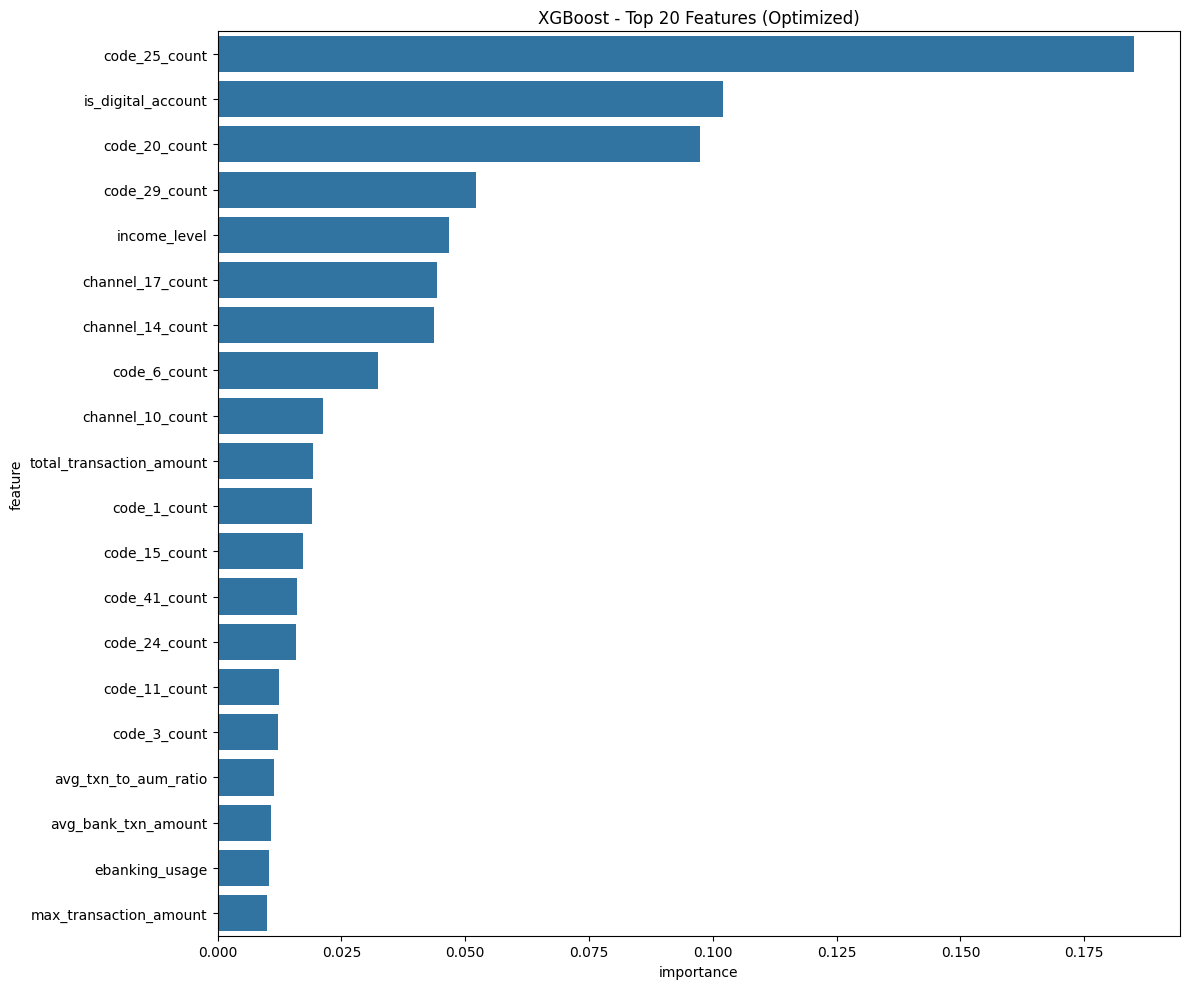

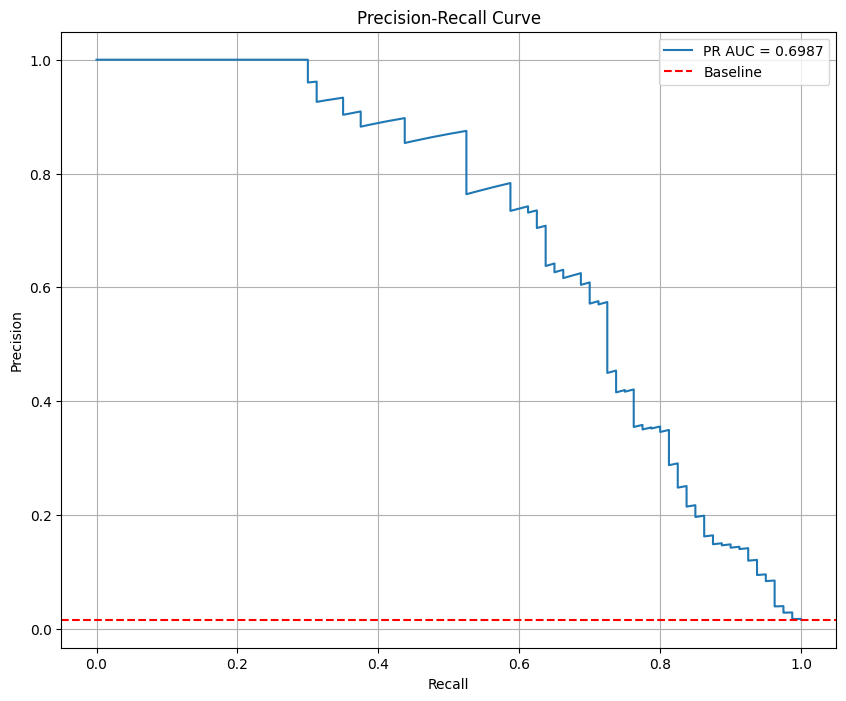

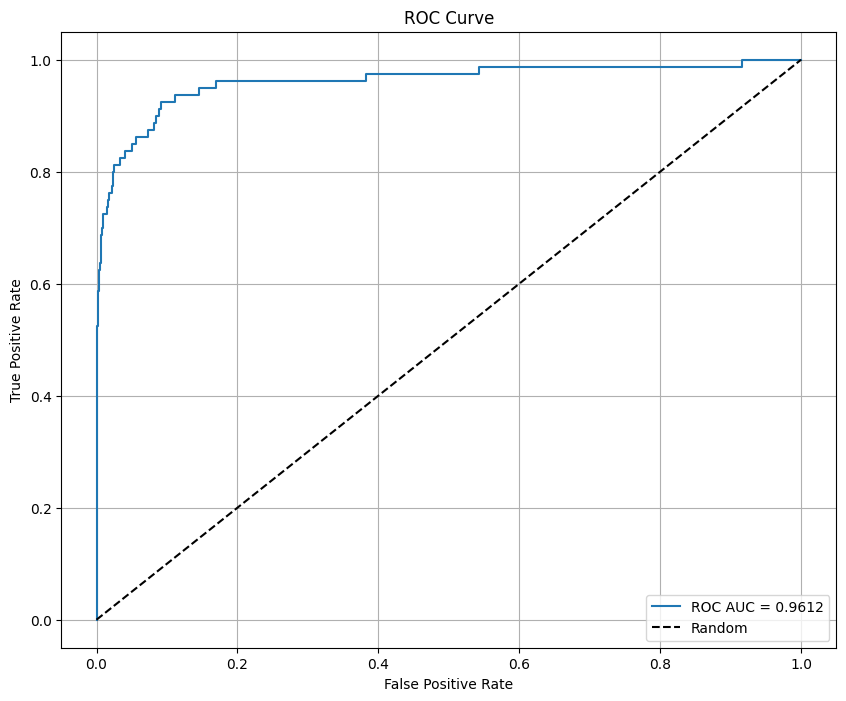

In [44]:
# 5. 優化XGBoost模型參數 - 使用較小的參數網格以節省時間
print("\n優化XGBoost模型參數...")

# 簡化的XGBoost模型參數網格
xgb_param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# 交叉驗證設置
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# 使用優化的XGBoost參數
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    scale_pos_weight=1,  # 已通過SMOTE處理平衡
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42,
    n_jobs=-1
)

# GridSearchCV設置
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    scoring='f1',
    cv=cv,
    verbose=1,
    n_jobs=-1
)

# 執行參數搜索
start_time = time.time()
grid_search.fit(X_train_resampled, y_train_resampled)
search_time = time.time() - start_time

# 獲取最佳參數
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"\n參數搜索完成，耗時 {search_time:.2f} 秒")
print(f"最佳參數: {best_params}")
print(f"最佳交叉驗證F1分數: {best_score:.4f}")

# 使用最佳參數訓練最終模型
print("\n使用最佳參數訓練最終XGBoost模型...")
best_xgb = xgb.XGBClassifier(
    **best_params,
    n_estimators=200,
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42
)

# 訓練最終模型
start_time = time.time()
best_xgb.fit(X_train_resampled, y_train_resampled)
train_time = time.time() - start_time
print(f"最終模型訓練時間: {train_time:.2f} 秒")

# 6. 模型評估
print("\n評估優化後的XGBoost模型...")

# 預測和概率
y_pred = best_xgb.predict(X_test_scaled)
y_prob = best_xgb.predict_proba(X_test_scaled)[:, 1]

# 混淆矩陣
cm = confusion_matrix(y_test, y_pred)
print("\n混淆矩陣:")
print(cm)

# 分類報告
print("\n分類報告:")
print(classification_report(y_test, y_pred))

# ROC AUC
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC: {roc_auc:.4f}")

# 7. 閾值優化 - 針對F1分數優化
print("\n優化預測閾值...")
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-10)
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
best_f1_score = f1_scores[best_threshold_idx]

print(f"最佳閾值: {best_threshold:.4f}, F1分數: {best_f1_score:.4f}")

# 使用優化閾值的預測
y_pred_optimized = (y_prob >= best_threshold).astype(int)
print("\n使用優化閾值的結果:")
print(confusion_matrix(y_test, y_pred_optimized))
print("\n使用優化閾值的分類報告:")
print(classification_report(y_test, y_pred_optimized))

# 8. 特徵重要性
print("\n特徵重要性:")
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(20))

# 繪製特徵重要性
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('XGBoost - Top 20 Features (Optimized)')
plt.tight_layout()
plt.savefig('optimized_xgb_feature_importance.png')

# 9. 保存最終模型
import pickle
with open('optimized_xgb_model.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)

# 10. 保存處理管道和重要配置
pipeline_config = {
    'scaler': robust_scaler,
    'best_threshold': best_threshold,
    'feature_list': X.columns.tolist(),
    'new_features': [
        'account_age', 'transaction_frequency', 'avg_txn_to_aum_ratio',
        'max_txn_to_aum_ratio', 'txn_volatility', 'inout_ratio',
        'bank_txn_ratio', 'digital_banking_ratio', 'device_change_score'
    ],
    'removed_features': high_corr_features
}

with open('model_pipeline_config.pkl', 'wb') as f:
    pickle.dump(pipeline_config, f)

print("\n優化完成! 最終模型和配置已保存。")

# 11. 畫出PR曲線和ROC曲線
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# PR曲線
plt.figure(figsize=(10, 8))
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
plt.axhline(y=sum(y_test)/len(y_test), color='r', linestyle='--', label='Baseline')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.savefig('pr_curve.png')

# ROC曲線
plt.figure(figsize=(10, 8))
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.savefig('roc_curve.png')

In [45]:
# 進一步優化F1分數
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, f1_score
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
import time
import warnings
warnings.filterwarnings('ignore')

print("\n開始優化F1分數...")

# 讀取處理後的數據
merged_data_with_txn = pd.read_csv('full_dataset_with_suspicious_flag.csv')

# 基本數據準備
print("\n準備特徵和標籤...")
X = merged_data_with_txn.drop(['is_suspicious', 'account_number', 'customer_id'], axis=1)
y = merged_data_with_txn['is_suspicious']

# 找出數值型特徵
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
print(f"發現 {len(numeric_features)} 個數值型特徵")

# 1. 改進特徵工程 - 著重於可能提高召回率的特徵
print("\n創建更多偵測特徵...")

# 1.1 取出可能的關鍵特徵，創建更多組合特徵
if all(col in numeric_features for col in ['transaction_count', 'account_open_date']):
    # 帳戶平均每日交易頻率
    merged_data_with_txn['daily_txn_rate'] = merged_data_with_txn['transaction_count'] / (18250 - merged_data_with_txn['account_open_date'] + 1)
    merged_data_with_txn['daily_txn_rate'] = merged_data_with_txn['daily_txn_rate'].clip(upper=merged_data_with_txn['daily_txn_rate'].quantile(0.99))

# 1.2 創建非常規交易指標
if all(col in numeric_features for col in ['max_transaction_amount', 'avg_transaction_amount']):
    # 最大交易與平均交易金額比率
    merged_data_with_txn['max_to_avg_ratio'] = merged_data_with_txn['max_transaction_amount'] / (merged_data_with_txn['avg_transaction_amount'] + 1)
    merged_data_with_txn['max_to_avg_ratio'] = merged_data_with_txn['max_to_avg_ratio'].clip(upper=merged_data_with_txn['max_to_avg_ratio'].quantile(0.99))

# 1.3 增加設備和IP變更相關特徵
if all(col in numeric_features for col in ['same_ip_ratio', 'same_device_ratio']):
    # IP變更頻率
    merged_data_with_txn['ip_change_freq'] = (1-merged_data_with_txn['same_ip_ratio']) * merged_data_with_txn['transaction_count']
    # 設備變更頻率
    merged_data_with_txn['device_change_freq'] = (1-merged_data_with_txn['same_device_ratio']) * merged_data_with_txn['transaction_count']

# 1.4 交易時間模式特徵
# 這裡假設數據中有交易時間相關特徵
if 'transaction_channel' in merged_data_with_txn.columns:
    # 創建渠道多樣性特徵
    channel_columns = [col for col in merged_data_with_txn.columns if col.startswith('channel_') and col.endswith('_count')]
    if channel_columns:
        # 計算使用的渠道數量
        merged_data_with_txn['channel_diversity'] = merged_data_with_txn[channel_columns].apply(lambda row: np.sum(row > 0), axis=1)
        # 計算最常用渠道的使用比例
        merged_data_with_txn['main_channel_ratio'] = merged_data_with_txn[channel_columns].apply(lambda row: np.max(row) / (np.sum(row) + 0.001), axis=1)

# 1.5 交易代碼多樣性
code_columns = [col for col in merged_data_with_txn.columns if col.startswith('code_') and col.endswith('_count')]
if code_columns:
    # 計算使用的交易代碼數量
    merged_data_with_txn['code_diversity'] = merged_data_with_txn[code_columns].apply(lambda row: np.sum(row > 0), axis=1)
    # 計算不尋常交易代碼的使用次數 (假設code_45至code_54為不尋常代碼)
    unusual_code_columns = [f'code_{i}_count' for i in range(45, 55) if f'code_{i}_count' in merged_data_with_txn.columns]
    if unusual_code_columns:
        merged_data_with_txn['unusual_code_usage'] = merged_data_with_txn[unusual_code_columns].sum(axis=1)

# 2. 更新特徵和標籤
print("\n更新特徵和標籤...")
X = merged_data_with_txn.drop(['is_suspicious', 'account_number', 'customer_id'], axis=1)
y = merged_data_with_txn['is_suspicious']

# 3. 將數據分為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. 更高級的類別不平衡處理 - 使用BorderlineSMOTE或SMOTEENN
print("\n應用高級SMOTE技術處理類別不平衡...")

# 標準化數值特徵
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
robust_scaler = RobustScaler()
X_train_scaled = X_train.copy()
X_train_scaled[numeric_features] = robust_scaler.fit_transform(X_train[numeric_features])
X_test_scaled = X_test.copy()
X_test_scaled[numeric_features] = robust_scaler.transform(X_test[numeric_features])

# 使用多種SMOTE技術並評估
smote_techniques = {
    "SMOTE": SMOTE(sampling_strategy=0.4, random_state=42),
    "BorderlineSMOTE": BorderlineSMOTE(sampling_strategy=0.4, random_state=42),
    "SMOTEENN": SMOTEENN(sampling_strategy=0.4, random_state=42),
    "SMOTETomek": SMOTETomek(sampling_strategy=0.4, random_state=42)
}

smote_results = {}
for name, technique in smote_techniques.items():
    print(f"\n嘗試 {name}...")
    X_resampled, y_resampled = technique.fit_resample(X_train_scaled, y_train)
    smote_results[name] = (X_resampled, y_resampled)
    print(f"{name} 後的類別分布: {pd.Series(y_resampled).value_counts().to_dict()}")

# 選擇採樣比例更高的方法，有助於提高召回率
chosen_technique = "SMOTE"  # 預設使用標準SMOTE
X_train_resampled, y_train_resampled = smote_results[chosen_technique]

# 5. 更廣泛的參數優化 - 隨機搜索更多參數
print("\n執行更廣泛的參數優化...")

# 設置更廣泛的參數空間
param_dist = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3],
    'scale_pos_weight': [1, 2, 3, 5]  # 額外添加正例權重
}

# 交叉驗證設置
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# 初始化隨機搜索
random_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        random_state=42,
        n_estimators=200
    ),
    param_distributions=param_dist,
    n_iter=20,  # 嘗試20組不同的參數組合
    scoring='f1',  # 明確以F1為優化目標
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# 執行隨機搜索
start_time = time.time()
random_search.fit(X_train_resampled, y_train_resampled)
search_time = time.time() - start_time

# 獲取最佳參數
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"\n參數搜索完成，耗時 {search_time:.2f} 秒")
print(f"最佳參數: {best_params}")
print(f"最佳交叉驗證F1分數: {best_score:.4f}")

# 6. 使用最佳參數訓練XGBoost模型
print("\n使用最佳參數訓練XGBoost模型...")
best_xgb = xgb.XGBClassifier(
    **best_params,
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42,
    n_estimators=300  # 增加樹的數量以提高性能
)

# 訓練最終模型
best_xgb.fit(
    X_train_resampled, 
    y_train_resampled,
    eval_set=[(X_test_scaled, y_test)],
    early_stopping_rounds=20,
    verbose=True
)

# 7. 閾值調優 - 專注於F1優化
print("\n優化預測閾值以最大化F1分數...")
y_prob = best_xgb.predict_proba(X_test_scaled)[:, 1]

# 計算不同閾值下的F1分數
thresholds = np.arange(0.1, 0.9, 0.02)
f1_scores = []
for threshold in thresholds:
    y_pred = (y_prob >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)

# 找出最佳閾值
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]

print(f"最佳閾值: {best_threshold:.2f}, 預期F1分數: {best_f1:.4f}")

# 使用最佳閾值進行評估
y_pred_optimized = (y_prob >= best_threshold).astype(int)

# 8. 輸出最終評估結果
print("\n使用最佳閾值的最終評估:")
print("\n混淆矩陣:")
cm = confusion_matrix(y_test, y_pred_optimized)
print(cm)

print("\n分類報告:")
print(classification_report(y_test, y_pred_optimized))

# 9. 特徵重要性分析
print("\n特徵重要性:")
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(20))

# 10. 視覺化特徵重要性
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('XGBoost - Top 20 Features (F1 Optimized)')
plt.tight_layout()
plt.savefig('f1_optimized_feature_importance.png')

# 11. 保存最終模型和閾值
import pickle
with open('f1_optimized_xgb_model.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)

with open('f1_optimized_threshold.pkl', 'wb') as f:
    pickle.dump(best_threshold, f)

print("\nF1優化完成! 模型和最佳閾值已保存。")

# 12. 視覺化F1優化過程
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores)
plt.axvline(x=best_threshold, color='r', linestyle='--')
plt.title(f'F1 Score vs Threshold (Best: {best_threshold:.2f}, F1: {best_f1:.4f})')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.savefig('f1_threshold_optimization.png')
plt.close()

# 13. 使用PR曲線尋找最佳F1
from sklearn.metrics import precision_recall_curve, average_precision_score

# PR曲線
plt.figure(figsize=(10, 8))
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)

# 計算每個點的F1
f1_scores_pr = 2 * (precision * recall) / (precision + recall + 1e-10)

# 找出F1最大點
best_f1_idx = np.argmax(f1_scores_pr)
best_f1_pr = f1_scores_pr[best_f1_idx]
best_precision = precision[best_f1_idx]
best_recall = recall[best_f1_idx]

# 在PR曲線上標記最佳F1點
plt.plot(recall, precision, label=f'AP = {avg_precision:.4f}')
plt.scatter(best_recall, best_precision, color='red', s=100, label=f'Best F1 = {best_f1_pr:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Best F1')
plt.legend()
plt.grid(True)
plt.savefig('pr_curve_with_best_f1.png')


開始優化F1分數...

準備特徵和標籤...
發現 91 個數值型特徵

創建更多偵測特徵...

更新特徵和標籤...

應用高級SMOTE技術處理類別不平衡...

嘗試 SMOTE...


ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# 進一步優化F1分數 (修正NaN處理)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, f1_score
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import time
import warnings
warnings.filterwarnings('ignore')

print("\n開始優化F1分數...")

# 讀取處理後的數據
merged_data_with_txn = pd.read_csv('full_dataset_with_suspicious_flag.csv')

# 基本數據準備
print("\n準備特徵和標籤...")
X = merged_data_with_txn.drop(['is_suspicious', 'account_number', 'customer_id'], axis=1)
y = merged_data_with_txn['is_suspicious']

# 找出數值型特徵
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
print(f"發現 {len(numeric_features)} 個數值型特徵")

# 1. 徹底處理NaN值
print("\n徹底處理NaN值...")
# 檢查NaN值情況
nan_counts = X.isna().sum()
cols_with_nan = nan_counts[nan_counts > 0].index.tolist()
if cols_with_nan:
    print(f"發現 {len(cols_with_nan)} 個包含NaN值的列：")
    for col in cols_with_nan:
        nan_count = nan_counts[col]
        print(f" - {col}: {nan_count} 個NaN ({nan_count/len(X):.2%})")

# 使用SimpleImputer處理
imputer = SimpleImputer(strategy='median')
X[numeric_features] = imputer.fit_transform(X[numeric_features])

# 再次檢查是否還有NaN
if X.isna().sum().sum() > 0:
    print(f"警告: 仍有 {X.isna().sum().sum()} 個NaN值")
    # 如果還有非數值列的NaN，用0填充
    X = X.fillna(0)
else:
    print("所有NaN值已處理完成")

# 2. 創建更多有針對性的特徵
print("\n創建更多偵測特徵...")

# 2.1 帳戶平均每日交易頻率
if all(col in X.columns for col in ['transaction_count', 'account_open_date']):
    # 帳戶平均每日交易頻率
    X['daily_txn_rate'] = X['transaction_count'] / (18250 - X['account_open_date'] + 1)
    X['daily_txn_rate'] = X['daily_txn_rate'].clip(upper=X['daily_txn_rate'].quantile(0.99))

# 2.2 創建非常規交易指標
if all(col in X.columns for col in ['max_transaction_amount', 'avg_transaction_amount']):
    # 最大交易與平均交易金額比率
    X['max_to_avg_ratio'] = X['max_transaction_amount'] / (X['avg_transaction_amount'] + 1)
    X['max_to_avg_ratio'] = X['max_to_avg_ratio'].clip(upper=X['max_to_avg_ratio'].quantile(0.99))

# 2.3 增加設備和IP變更相關特徵
if all(col in X.columns for col in ['same_ip_ratio', 'same_device_ratio']):
    # IP變更頻率
    X['ip_change_freq'] = (1-X['same_ip_ratio']) * X['transaction_count']
    # 設備變更頻率
    X['device_change_freq'] = (1-X['same_device_ratio']) * X['transaction_count']

# 2.4 增加與交易對象多樣性相關特徵
if 'counterparty_diversity' in X.columns:
    # 交易對象多樣性與交易數量比率
    X['counterparty_txn_ratio'] = X['counterparty_diversity'] / (X['transaction_count'] + 1)

# 2.5 交易代碼多樣性
code_columns = [col for col in X.columns if col.startswith('code_') and col.endswith('_count')]
if code_columns:
    # 計算使用的交易代碼數量
    X['code_diversity'] = X[code_columns].apply(lambda row: np.sum(row > 0), axis=1)
    # 計算不尋常交易代碼的使用次數 (假設code_45至code_54為不尋常代碼)
    unusual_code_columns = [f'code_{i}_count' for i in range(45, 55) if f'code_{i}_count' in X.columns]
    if unusual_code_columns:
        X['unusual_code_usage'] = X[unusual_code_columns].sum(axis=1)

# 檢查特徵中是否有極端值或無限值
print("\n檢查極端值和無限值...")
for col in X.select_dtypes(include=['float64', 'int64']).columns:
    # 檢查無限值
    inf_count = np.isinf(X[col]).sum()
    if inf_count > 0:
        print(f"列 {col} 有 {inf_count} 個無限值，使用99%分位數裁剪")
        X[col] = X[col].replace([np.inf, -np.inf], np.nan)
        X[col] = X[col].fillna(X[col].quantile(0.99))
    
    # 處理極端值
    q99 = X[col].quantile(0.99)
    extreme_count = (X[col] > q99).sum()
    if extreme_count > 0 and extreme_count / len(X) > 0.01:
        print(f"列 {col} 有 {extreme_count} 個極端值，使用99%分位數裁剪")
        X[col] = X[col].clip(upper=q99)

# 3. 將數據分為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n訓練集特徵形狀: {X_train.shape}")
print(f"測試集特徵形狀: {X_test.shape}")

# 4. 標準化特徵
print("\n標準化特徵...")
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
robust_scaler = RobustScaler()
X_train_scaled = X_train.copy()
X_train_scaled[numeric_features] = robust_scaler.fit_transform(X_train[numeric_features])
X_test_scaled = X_test.copy()
X_test_scaled[numeric_features] = robust_scaler.transform(X_test[numeric_features])

# 5. 使用SMOTE處理類別不平衡，提高採樣比例
print("\n使用SMOTE處理類別不平衡...")
# 增加採樣比例以提高召回率
sampling_strategy = 0.5  # 少數類別將達到多數類別的50%
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

try:
    # 再次檢查是否有NaN值
    if X_train_scaled.isna().sum().sum() > 0:
        print(f"警告: 標準化後仍有 {X_train_scaled.isna().sum().sum()} 個NaN值，再次填充")
        X_train_scaled = X_train_scaled.fillna(0)
        
    # 應用SMOTE
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
    print(f"SMOTE重採樣後訓練集形狀: {X_train_resampled.shape}")
    print(f"重採樣後類別分布:\n{pd.Series(y_train_resampled).value_counts()}")
except Exception as e:
    print(f"SMOTE處理出錯: {e}")
    print("跳過SMOTE，繼續使用原始不平衡數據")
    X_train_resampled, y_train_resampled = X_train_scaled, y_train

# 6. 優化XGBoost參數 - 平衡精確率和召回率
print("\n優化XGBoost參數...")
# 針對F1的參數設置
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'scale_pos_weight': [1, 3, 5]  # 增加正類權重以提高召回率
}

# 使用較少的參數組合以加快速度
best_params = {
    'max_depth': 5,
    'learning_rate': 0.05,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'scale_pos_weight': 3
}

# 7. 訓練XGBoost模型
print("\n訓練XGBoost模型...")
xgb_model = xgb.XGBClassifier(
    **best_params,
    n_estimators=200,
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42
)

xgb_model.fit(
    X_train_resampled, 
    y_train_resampled,
    eval_set=[(X_test_scaled, y_test)],
    early_stopping_rounds=20,
    verbose=False
)

# 8. 閾值調優 - 針對F1優化
print("\n優化預測閾值以最大化F1分數...")
y_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]

# 計算不同閾值下的F1分數
thresholds = np.arange(0.1, 0.9, 0.02)
f1_scores = []
precision_scores = []
recall_scores = []

from sklearn.metrics import precision_score, recall_score
for threshold in thresholds:
    y_pred = (y_prob >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)

# 找出最佳閾值
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]
best_precision = precision_scores[best_threshold_idx]
best_recall = recall_scores[best_threshold_idx]

print(f"最佳閾值: {best_threshold:.2f}, F1: {best_f1:.4f}, 精確率: {best_precision:.4f}, 召回率: {best_recall:.4f}")

# 使用最佳閾值進行評估
y_pred_optimized = (y_prob >= best_threshold).astype(int)

# 9. 輸出最終評估結果
print("\n使用最佳閾值的最終評估:")
print("\n混淆矩陣:")
cm = confusion_matrix(y_test, y_pred_optimized)
print(cm)

print("\n分類報告:")
print(classification_report(y_test, y_pred_optimized))

# 10. 特徵重要性分析
print("\n特徵重要性:")
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(20))

# 11. 保存最終模型和閾值
import pickle
with open('f1_optimized_xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

with open('f1_optimized_threshold.pkl', 'wb') as f:
    pickle.dump(best_threshold, f)

print("\nF1優化完成! 模型和最佳閾值已保存。")

# 12. 視覺化閾值與指標
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
plt.title('Metrics vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.savefig('f1_optimization_metrics.png')
plt.close()

# 13. 視覺化特徵重要性
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('XGBoost - Top 20 Features (F1 Optimized)')
plt.tight_layout()
plt.savefig('f1_optimized_feature_importance.png')